In [1]:
from glob import glob
from datetime import datetime

import numpy as np
import pandas as pd
# import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, BertTokenizer, EarlyStoppingCallback
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer, TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
import optuna 

from arabert.preprocess import ArabertPreprocessor
from transformers.integrations import TensorBoardCallback
from torch.utils.tensorboard import SummaryWriter

# Parameters

In [2]:
# Config
device = torch.device("cuda")

# Data params
validation_size = 5000

# Model params
model_name = "aubmindlab/bert-base-arabertv2"
model = AutoModel.from_pretrained(model_name)
for param in model.parameters():
    param.requires_grad = False
    
# Preprocessing params
sequence_length = 100
arabert_prep = ArabertPreprocessor(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2021-09-14 22:25:01,454 - farasapy_logger - WARNING]: Be careful with large lines as they may break on intera

# Functions

In [4]:
def get_SMADC_folder_data():
    """Returns a dataframe with Text and Region columns. Requires tree like this data/SMADC/*.txt"""
    files = glob("data/SMADC/*.txt")
    dataframes = []

    for file in files:
        region = file[-7:-4]
        temp_df = pd.read_csv(file, encoding="utf8", delimiter="\n", names=["Text"])
        temp_df["Region"] = region
        dataframes.append(temp_df)
        
    return pd.concat(dataframes)


def get_music_df():
    files = ["GLF","LEV","NOR","IRQ"]
    dataframes = []
    
    for file in files:
        temp_df = pd.read_csv(f'../extra_data/d7_data/{file}.txt', encoding="utf8", delimiter="\n", names=["Text"])
        temp_df["Region"] = file
        dataframes.append(temp_df)
    
    return pd.concat(dataframes)


def tokenize(batch):
    """
    Tokenizes a list of strings
    Warning: This function uses global variable tokenizer and global variable sequence_length
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    batch = tokenizer.batch_encode_plus(
        batch,
        add_special_tokens=True,
        padding=True,
        max_length=sequence_length,
        truncation=True,
        return_tensors="pt",
        return_attention_mask=True,
        return_token_type_ids=False
    )
#     batch["input_ids"] = batch["input_ids"].to(device)
#     batch["attention_mask"] = batch["attention_mask"].to(device)
    return batch


def preprocess_sample(sample):
    """Sample list of strings"""
    return tokenize(list(arabert_prep.preprocess(text) for text in sample))


def save_preprocessed_data(dataset, dataset_name):
    with shelve.open("data/preprocessed_data") as db:
        db[dataset_name] = dataset
        
def load_preprocessed_data():
    with shelve.open("data/preprocessed_data") as db:
        train_dataset = db["train_dataset"]
        validate_dataset = db["validate_dataset"]
        test_dataset = db["test_dataset"]
    return train_dataset, validate_dataset, test_dataset


def compute_metrics(p): 
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    macro_precision = precision_score(p.label_ids,preds,average='macro')
    macro_recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
    }


def model_init(model_name, num_labels, label2id, id2label):
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=num_labels, label2id=label2id, id2label=id2label)

# Data

In [7]:
%%time 
# Data logic (load, arabic_preprocess, tokenize, dataset)

# Date to dataframe (2.9 s)
df = get_SMADC_folder_data()
df = df[:5000]
# Encode Y (307 ms)
classes = df["Region"].unique()
num_labels = len(classes)
class_to_index = {class_:index for class_, index in zip(classes, range(len(classes)))}
index_to_class = {index:class_ for class_, index in zip(classes, range(len(classes)))}
df["Labels"] = df["Region"].apply(class_to_index.get)
# all_labels = torch.tensor(df["Region"].map(class_to_index.get).values)
# all_labels = all_labels.to(device)

# Preprocess X (16min 22s)
df["Text"] = df["Text"].apply(arabert_prep.preprocess)

# split and tokenize (~2min 26s)
train, test = train_test_split(df, test_size=0.1, random_state=1)
validate, test = train_test_split(test, test_size=len(test)-1, random_state=1)
train.reset_index(drop=True, inplace=True)
validate.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
x_train, x_test, x_validate = tokenize(train["Text"].to_list()), tokenize(test["Text"].to_list()), tokenize(validate["Text"].to_list())

# Dataset class
class Dialect_dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        super(Dialect_dataset).__init__()
        self.X = X
        self.Y = Y
        
    def __getitem__(self, key):
        return InputFeatures(self.X["input_ids"][key], self.X["attention_mask"][key], label=self.Y[key])
        
    def __len__(self):
        return len(self.Y)
    
# Make Dataset
train_dataset = Dialect_dataset(x_train, train["Labels"].to_list())
validate_dataset = Dialect_dataset(x_validate, validate["Labels"].to_list())
test_dataset = Dialect_dataset(x_test, test["Labels"].to_list())

Wall time: 22.2 s


In [6]:
import shelve
# save_preprocessed_data(train_dataset, "train_dataset")
# save_preprocessed_data(validate_dataset, "validate_dataset")
# save_preprocessed_data(test_dataset, "test_dataset")# 
train_dataset, validate_dataset, test_dataset = load_preprocessed_data()

AttributeError: Can't get attribute 'Dialect_dataset' on <module '__main__'>

# Training

In [8]:
dialect_classifier = model_init(model_name, len(classes), label2id=class_to_index, id2label=index_to_class)
dialect_classifier = dialect_classifier.to(device)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

In [9]:
training_args = TrainingArguments(f"./train/{str(datetime.today().date())}-train")

# training_args.adam_epsilon = 1e-8
# training_args.learning_rate = 5e-5

training_args.fp16 = True

training_args.per_device_train_batch_size = 32
training_args.per_device_eval_batch_size = 32

training_args.gradient_accumulation_steps = 2

training_args.num_train_epochs= 6

steps_per_epoch = len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)
total_steps = steps_per_epoch * training_args.num_train_epochs
print(f"Steps per epoch: {steps_per_epoch}. Total steps: {total_steps}")

warmup_ratio = 0.05
training_args.warmup_steps = total_steps*warmup_ratio 

training_args.logging_steps = 500
training_args.evaluation_strategy = "steps"
training_args.load_best_model_at_end = True
training_args.eval_steps = 1000

training_args.save_steps = 10000
training_args.save_total = 10 

training_args.seed = 1

training_args.lr_scheduler_type = 'cosine'

training_args.metric_for_best_model= "eval_loss"

Steps per epoch: 70. Total steps: 420


In [31]:
from collections import namedtuple
from typing import Any

# pylint: disable = abstract-method
class ModelWrapper(torch.nn.Module):
    def __init__(self, model: torch.nn.Module) -> None:
        super().__init__()
        self.model = model

    def forward(self, input_x: torch.Tensor) -> Any:
        data = self.model(input_x)

        if isinstance(data, dict):
            data_named_tuple = namedtuple("ModelEndpoints", sorted(data.keys()))  # type: ignore
            data = data_named_tuple(**data)  # type: ignore

        elif isinstance(data, list):
            data = tuple(data)

        return data

In [37]:
writer = SummaryWriter()
writer.add_graph(ModelWrapper(dialect_classifier),x_validate["input_ids"].cuda())

In [33]:
trainer = Trainer(
    model=dialect_classifier,
    model_init=lambda:model_init(model_name, len(classes), label2id=class_to_index, id2label=index_to_class),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3), TensorBoardCallback(writer)]
)

C:\Users\Abdul\anaconda3\envs\SHIT\lib\site-packages\transformers\trainer.py:266: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  warnings.warn(
You are adding a <class 'transformers.integrations.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
EarlyStoppingCallback


In [34]:
!tensorboard --logdir=runs
# go to http://localhost:6006/ to see the board when you tarin

^C


In [36]:
trainer.train()

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

RuntimeError: Found dtype Long but expected Float

# Evaluation

In [ ]:
trainer.eval_dataset(test_dataset)

# Analysis

In [50]:
history = pd.DataFrame(trainer.state.log_history)
history

,loss,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,eval_loss,eval_macro_f1,eval_macro_precision,eval_macro_recall,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.9106,4.999982e-05,0.01,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.7307,4.999928e-05,0.01,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.6905,4.999837e-05,0.02,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.6774,4.999710e-05,0.02,800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.6602,4.999547e-05,0.03,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,0.1524,9.375026e-10,4.99,164600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
823,0.1548,2.944638e-10,4.99,164800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
824,0.1567,1.369865e-11,5.00,165000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
825,NaN,NaN,5.00,165055,42628.1851,123.902,3.872,2.714285e+17,0.300981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


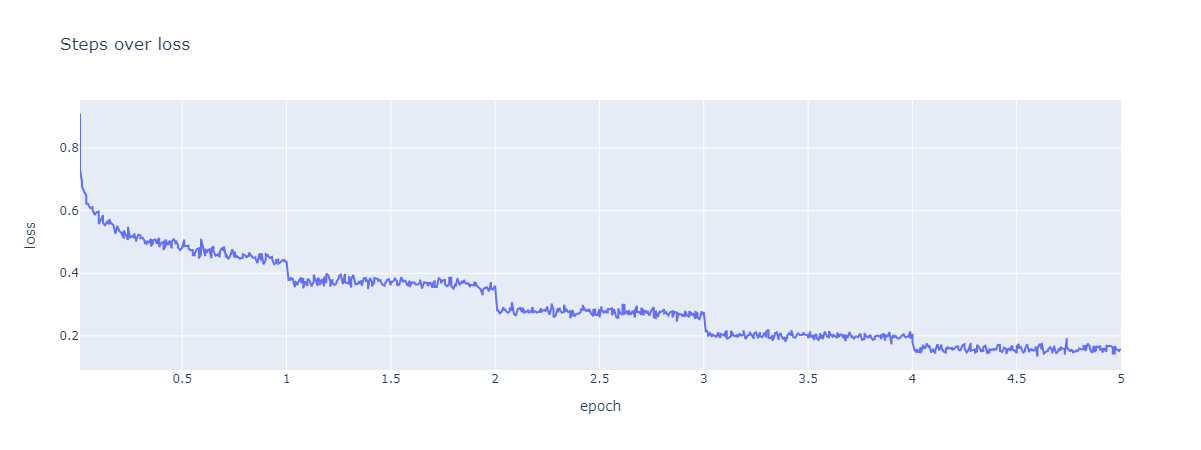

In [52]:
history.plot(x="step", y="loss", backend="plotly", title="Steps over loss")

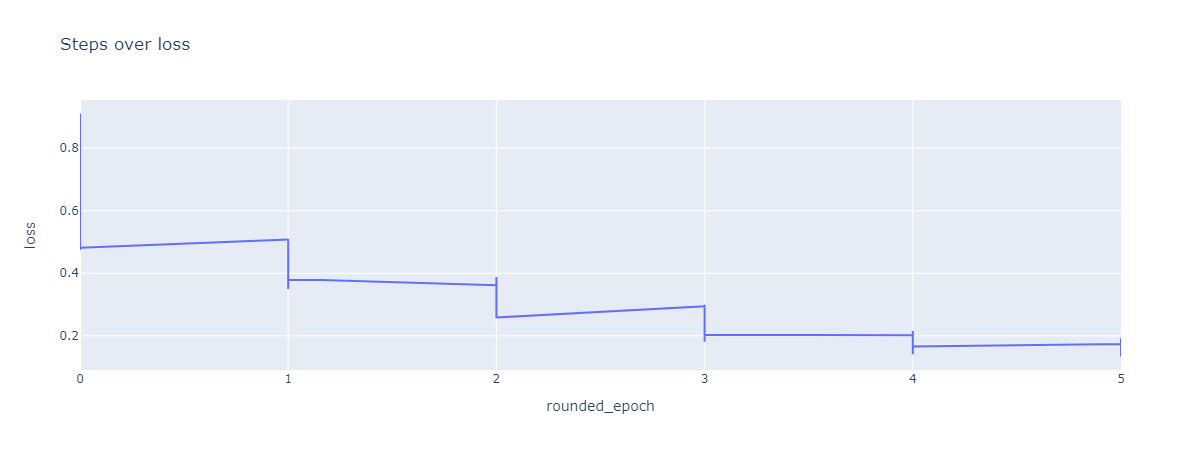

In [54]:
history["rounded_epoch"] = round(history["epoch"])
history.plot(x="rounded_epoch", y="loss", backend="plotly", title="Steps over loss")

In [75]:
# fig = px.line(history, x="step", y="loss", title="Steps over loss")
# fig.add_trace(
#     next(px.line(history, x="step", y="").select_traces())
# )
# fig.show()


# Hyperparameter search

In [ ]:
trainer.hyperparameter_search(n_trials=100)